In [1]:
import pandas as pd
import numpy as np
import warnings 
warnings.filterwarnings("ignore")
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import ks_2samp
# from scipy.stats import norm

In [2]:
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import cross_validate 
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.inspection import permutation_importance

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn import metrics
import xgboost as xgb
from xgboost.sklearn import XGBClassifier

## Nôi dung 
### <a href='#1'> 1. Xử lý dữ liệu
#### <a href='#1.1'> 1.1. Đưa dữ liệu json về dạng bảng
#### <a href='#1.2'> 1.2. Feature Engineering (biến đổi các thuộc tính, thêm các thuộc tính mới)
#### <a href='#1.3'> 1.3. Kiểm tra phân phối của dữ liệu
#### <a href='#1.4'> 1.4. Kiểm tra tính cân bằng dữ liệu
#### <a href='#1.5'> 1.5. Outlier
### <a href='#2'> 2. Phân tích mô tả
#### <a href='#2.1'> 2.1. Đánh giá khả năng tác động từng thuộc tính nên kết quả mục tiêu 
#### <a href='#2.2'> 2.2. Đánh giá tương quan
### <a href='#3'> 3. Mô hình Random Forest
#### <a href='#3.1'> 3.1. Lựa chọn thuộc tính
#### <a href='#3.2'> 3.2. Xây dựng, tinh chỉnh và đánh giá mô hình
### <a href='#4'> 4. Mô hình XGBoost
#### <a href='#4.1'> 4.1. Xây dựng mô hình
#### <a href='#4.2'> 4.2. Tuning hyper-parameter

### <a id= '1'> 1. Xử lý dữ liệu

#### <a id= '1.1'> 1.1. Đưa dữ liệu json về dạng bảng

In [4]:
df=pd.read_csv(r'1MG.csv')

In [5]:
# 1.1.Đưa dữ liệu json về dạng bảng
df=df.reset_index()
import ast
df.transaction_info.apply(ast.literal_eval)
df2=pd.DataFrame(df.transaction_info.apply(ast.literal_eval).sum(),index=df.index.repeat(df.transaction_info.apply(ast.literal_eval).str.len())).reset_index()

,index,csn,date,transaction_info
0,0,Y2NgaWJoYw==,2018-03-02,"[{'article': '10020163', 'salesquantity': 2.0,..."
1,1,Y2NgaWJoYw==,2018-03-04,"[{'article': '10026562', 'salesquantity': 3.0,..."
2,2,Y2NgaWlpYA==,2018-02-27,"[{'article': '10013531', 'salesquantity': 1.0,..."
3,3,Y2NgaWlpYA==,2018-03-16,"[{'article': '10008991', 'salesquantity': 1.0,..."
4,4,Y2NgaWlpYA==,2018-05-24,"[{'article': '10009698', 'salesquantity': 1.0,..."
...,...,...,...,...
95,95,Y2Nha2ZmYw==,2018-03-18,"[{'article': '10083185', 'salesquantity': 1.0,..."
96,96,Y2Nha2hmZg==,2018-03-06,"[{'article': '10016393', 'salesquantity': 1.0,..."
97,97,Y2Nha2hmZg==,2018-04-12,"[{'article': '10013198', 'salesquantity': 1.0,..."
98,98,Y2Nha2hmZg==,2018-04-14,"[{'article': '10054854', 'salesquantity': 0.62..."


In [6]:
df=pd.merge(df[['csn','date', 'index']],df2,on='index',how='left')

#### <a id= '1.2'> 1.2. Feature Engineering (biến đổi các thuộc tính, thêm các thuộc tính mới)

In [8]:
#add column month
df['date']=pd.to_datetime(df['date'])
df['month'] = df['date'].dt.month

Dataset gồm các dữ liệu mua hàng từ tháng 2 đến tháng 6

Tính toán các thuộc tính phái sinh (theo tháng): 
- unique_item: số lượng loại item KH mua
- quantity: số lượng mua
- freq: tần suất (số lần) mua
- price: tổng tiền mua 

In [9]:
df2=df.groupby(['csn','month']).agg({'article': 'nunique','salesquantity': ['sum','count'], 'price': 'sum'}).reset_index()
df2.columns=['csn','month','unique_item','quantity','freq','price']

In [10]:
#thêm các tháng còn thiếu cho từng KH, đảm bảo có dữ liệu từng khách từ t2 đến t6. Các tháng thêm vào giá trị bằng 0
df_month=df2.set_index(['month', 'csn'])[['unique_item']].unstack().unstack().reset_index()
df2=pd.merge(df_month[['csn','month']], df2, on=['csn','month'], how='left').fillna(0)

In [11]:
#gắn nhãn dữ liệu
df2.loc[df2['price'] >0, 'purchase']=1
df2.loc[df2['price'] == 0, 'purchase']=0

In [12]:
#thuộc tính tương ứng 4 thuộc tính phái sinh (phía trên) tại thời điểm 1 tháng trước 
df2['unique_item_month'] = (df2.sort_values(by=['csn','month'], ascending=True) .groupby(['csn'])['unique_item'].shift(1)).fillna(0)
df2['quantity_month'] = (df2.sort_values(by=['csn','month'], ascending=True) .groupby(['csn'])['quantity'].shift(1)).fillna(0)
df2['freq_month'] = (df2.sort_values(by=['csn','month'], ascending=True) .groupby(['csn'])['freq'].shift(1)).fillna(0)
df2['price_month'] = (df2.sort_values(by=['csn','month'], ascending=True) .groupby(['csn'])['price'].shift(1)).fillna(0)

#thuộc tính tương ứng 4 thuộc tính phái sinh (phía trên) tại thời điểm 2 tháng trước 
df2['unique_item_2_month'] = (df2.sort_values(by=['csn','month'], ascending=True) .groupby(['csn'])['unique_item'].shift(2)).fillna(0)
df2['quantity_2_month'] = (df2.sort_values(by=['csn','month'], ascending=True) .groupby(['csn'])['quantity'].shift(2)).fillna(0)
df2['freq_2_month'] = (df2.sort_values(by=['csn','month'], ascending=True) .groupby(['csn'])['freq'].shift(2)).fillna(0)
df2['price_2_month'] = (df2.sort_values(by=['csn','month'], ascending=True) .groupby(['csn'])['price'].shift(2)).fillna(0)

Mô hình dự đoán khả năng mua dựa trên số liệu 2 tháng trước nên dữ liệu xâu dựng mô hình từ tháng 4 đến tháng 6

In [13]:
select=df2[df2['month']>3]
select 

,csn,month,unique_item,quantity,freq,price,purchase,unique_item_month,quantity_month,freq_month,price_month,unique_item_2_month,quantity_2_month,freq_2_month,price_2_month
2,Y2NgaWJoYw==,4,0.0,0.000,0.0,0.00,0.0,3.0,7.000,3.0,74250.00,0.0,0.000,0.0,0.00
3,Y2NgaWJoYw==,5,0.0,0.000,0.0,0.00,0.0,0.0,0.000,0.0,0.00,3.0,7.000,3.0,74250.00
4,Y2NgaWJoYw==,6,0.0,0.000,0.0,0.00,0.0,0.0,0.000,0.0,0.00,0.0,0.000,0.0,0.00
7,Y2NgaWlpYA==,4,0.0,0.000,0.0,0.00,0.0,5.0,6.000,5.0,579500.00,17.0,27.000,17.0,1343225.00
8,Y2NgaWlpYA==,5,4.0,9.000,4.0,207800.00,1.0,0.0,0.000,0.0,0.00,5.0,6.000,5.0,579500.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99993,amxpamJk,5,12.0,14.342,12.0,986904.26,1.0,11.0,12.166,11.0,805097.59,4.0,4.000,4.0,135000.00
99994,amxpamJk,6,0.0,0.000,0.0,0.00,0.0,12.0,14.342,12.0,986904.26,11.0,12.166,11.0,805097.59
99997,amxpbWNk,4,4.0,5.000,4.0,247700.00,1.0,0.0,0.000,0.0,0.00,0.0,0.000,0.0,0.00
99998,amxpbWNk,5,0.0,0.000,0.0,0.00,0.0,4.0,5.000,4.0,247700.00,0.0,0.000,0.0,0.00


#### <a id= '1.4'> 1.4. Kiểm tra tính cân bằng dữ liệu

In [14]:
#(2) Dữ liệu có mất cân bằng không?
select[select['purchase']==1]['purchase'].count()/select['purchase'].count()

0.4565666666666667

Dữ liệu không mất cân bằng

#### <a id= '1.5'> 1.5. Outlier

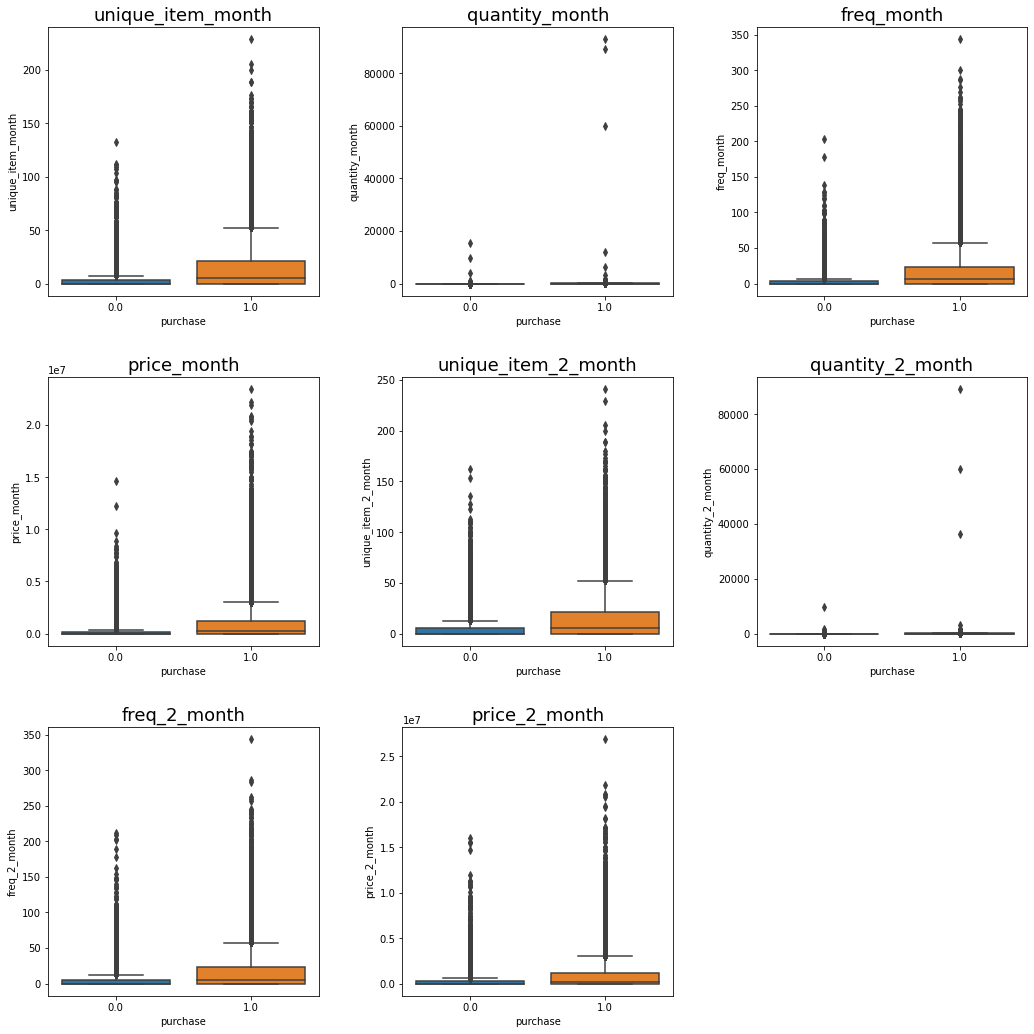

In [16]:
columns=['unique_item_month','quantity_month','freq_month','price_month','unique_item_2_month','quantity_2_month','freq_2_month','price_2_month']
fig=plt.figure(figsize=(15,15))
for i,j in enumerate(columns): 
    ax=fig.add_subplot(3,3,i+1)
    fig.tight_layout(pad=3.0)
    sns.boxplot(ax=ax,y = select[j], x = select['purchase']).set_title(str(j),size = 18)

In [20]:
#kiem tra outlier,ngưỡng 1,5iqr, đưa giá trị về đầu mút 1.5iqr
#kiem tra tỷ lệ outlier
df_iqr=select[columns].quantile([0.25,0.75],axis=0).T
df_iqr.columns=['q1','q3']
df_iqr['max_iqr']=df_iqr['q3'] + ((df_iqr['q3'] - df_iqr['q1'])*1.5)
df_iqr['min_iqr']=df_iqr['q1'] - ((df_iqr['q3'] - df_iqr['q1'])*1.5)
df_iqr['attr']=columns
a=[]
for i in columns:
    b=select[(select[i]>df_iqr.loc[i,'max_iqr'])|(select[i]<df_iqr.loc[i,'min_iqr'])][i].count()
    a.append(b)
df_iqr['nbr_outlier']=a
df_iqr['pct_outlier']=df_iqr['nbr_outlier']*100/select[columns].count()
df_iqr

,q1,q3,max_iqr,min_iqr,attr,nbr_outlier,pct_outlier
unique_item_month,0.0,10.0000,2.500000e+01,-15.00000,unique_item_month,6367,10.611667
quantity_month,0.0,14.1740,3.543500e+01,-21.26100,quantity_month,7570,12.616667
freq_month,0.0,10.0000,2.500000e+01,-15.00000,freq_month,6992,11.653333
price_month,0.0,473899.3800,1.184748e+06,-710849.07000,price_month,8210,13.683333
unique_item_2_month,0.0,11.0000,2.750000e+01,-16.50000,unique_item_2_month,6293,10.488333
quantity_2_month,0.0,16.4200,4.105000e+01,-24.63000,quantity_2_month,7120,11.866667
freq_2_month,0.0,12.0000,3.000000e+01,-18.00000,freq_2_month,6048,10.080000
price_2_month,0.0,571868.5625,1.429671e+06,-857802.84375,price_2_month,7490,12.483333


Tỷ lệ outlier 10-12% giá trị các thuộc tính. có thể thấy đối với purchase =1, giá trị outlier có xu hướng tập trung nhiều hơn => các giá trị outlier này là có ý nghĩa, giữ lại ko biến đổi.

### <a id= '2'> 2. Phân tích mô tả

#### <a id='2.1'> 2.1. Đánh giá khả năng tác động từng thuộc tính nên kết quả mục tiêu 

In [21]:
#Kiểm định K-S
ks_test=pd.DataFrame([],columns=['attributes','ks_statistic'])
for x in (columns):
    ks_test_add=pd.DataFrame([])
    a=select[select['purchase']==1][x].values
    b=select[select['purchase']==0][x].values
    ks_test_add['attributes']=[x]
    ks_test_add['ks_statistic']=ks_2samp(a, b).statistic
    ks_test=pd.concat([ks_test,ks_test_add],ignore_index=True)

In [22]:
ks_test

,attributes,ks_statistic
0,unique_item_month,0.304689
1,quantity_month,0.302287
2,freq_month,0.307655
3,price_month,0.297995
4,unique_item_2_month,0.246945
5,quantity_2_month,0.241305
6,freq_2_month,0.250711
7,price_2_month,0.237149


In [23]:
#Kiểm định t-test
t_test=pd.DataFrame([],columns=['attributes','ttest_pvalue'])
for x in (columns):
    t_test_add=pd.DataFrame([])
    a=select[select['purchase']==1][x].values
    b=select[select['purchase']==0][x].values
    t_test_add['attributes']=[x]
    t_test_add['ttest_pvalue']=stats.ttest_ind(a,b).pvalue
    t_test=pd.concat([t_test,t_test_add],ignore_index=True)

In [24]:
t_test

,attributes,ttest_pvalue
0,unique_item_month,0.000000e+00
1,quantity_month,6.666858e-09
2,freq_month,0.000000e+00
3,price_month,0.000000e+00
4,unique_item_2_month,0.000000e+00
5,quantity_2_month,5.735479e-10
6,freq_2_month,0.000000e+00
7,price_2_month,0.000000e+00


Với ngưỡng K-s >22%, p-value(t-test) < 0.05, qua kiểm định K-S và t-test, các biến đều có khả năng phân biệt khách hàng mua/không mua

#### <a id= '2.2'> 2.2. Đánh giá tương quan

<AxesSubplot:>

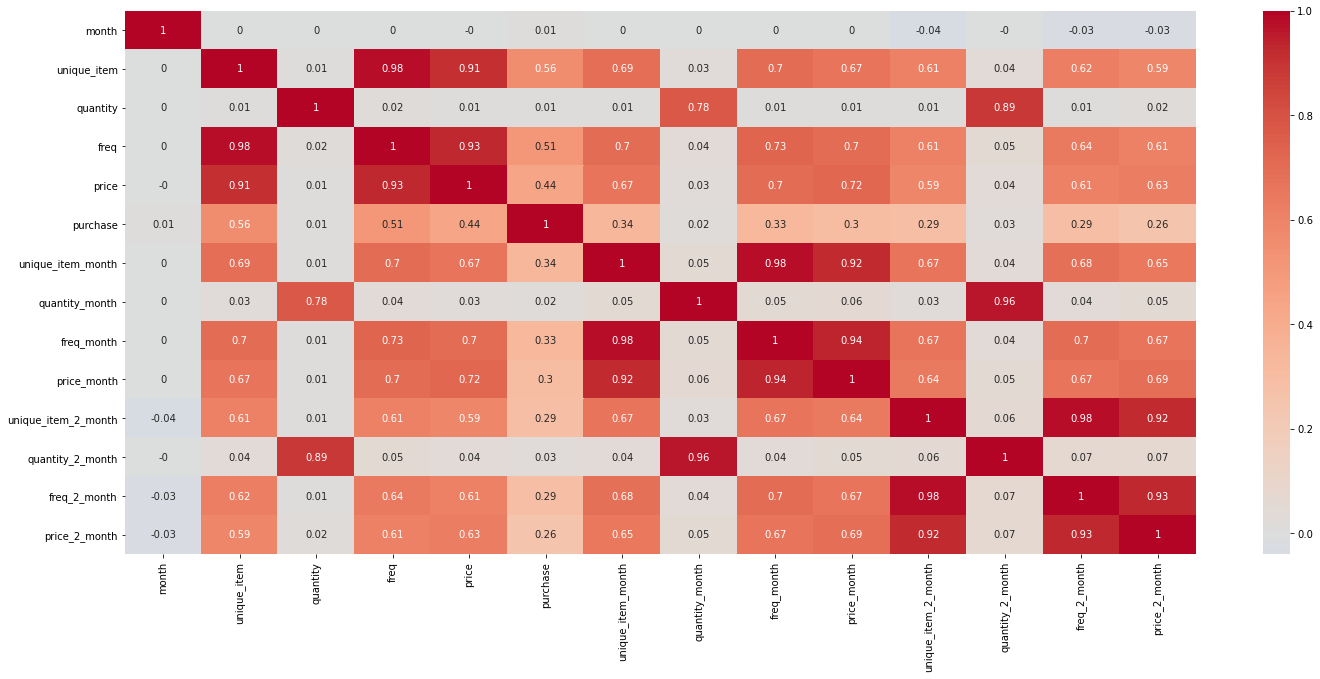

In [25]:
#ma trận tương quan giữa các biến 
corr=select.corr()
fig,ax=plt.subplots(figsize=(24,10))
sns.heatmap(corr.round(2),
            center=0,
            cmap='coolwarm',
            annot=True)

In [26]:
x=select[['unique_item_month','quantity_month','freq_month','price_month','unique_item_2_month','quantity_2_month','freq_2_month','price_2_month']]
y=select['purchase']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.30, random_state=1, stratify=y)

### <a id= '3'> 3. Mô hình RandomForest

#### <a id= '3.1'> 3.1. Lựa chọn thuộc tính phương pháp tính permutation importance

In [27]:
rf_model= RandomForestClassifier(n_estimators = 100,random_state=42)
rf_model.fit(x_train, y_train)

RandomForestClassifier(random_state=42)

In [28]:
result = permutation_importance(rf_model, x_train, y_train, n_repeats=5,random_state=42, n_jobs=2)
sorted_idx = result.importances_mean.argsort()

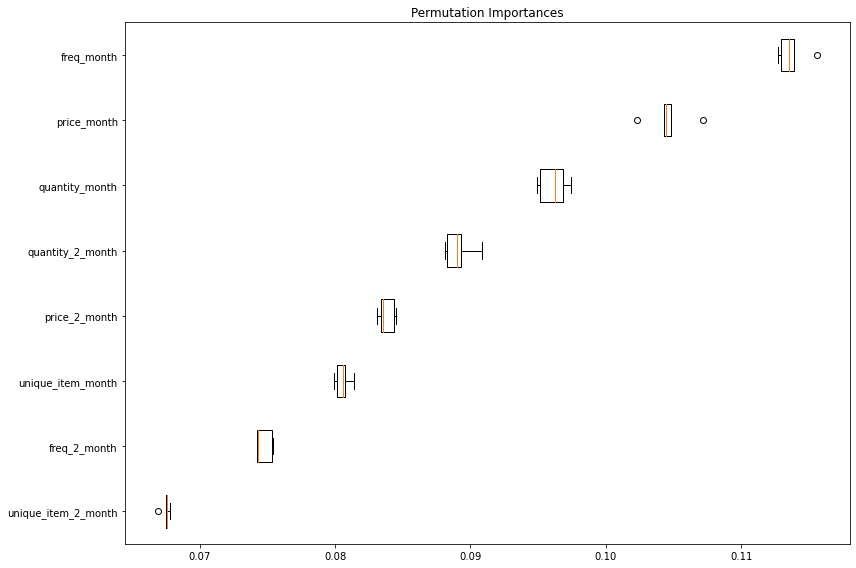

In [29]:
fig, ax = plt.subplots(figsize=(12,8))
ax.boxplot(result.importances[sorted_idx].T,vert=False, labels=x_train.columns[sorted_idx])
ax.set_title("Permutation Importances")
fig.tight_layout()
plt.show()

Lấy top 7 feature importance để xây dựng mô hình: ['unique_item_month','quantity_month','freq_month','price_month','quantity_2_month','price_2_month','freq_2_month']

#### <a id= '3.2'> 3.2. Xây dựng, tinh chỉnh và đánh giá mô hình

In [30]:
x_train_selected=x_train[['unique_item_month','quantity_month','freq_month','price_month','quantity_2_month','price_2_month','freq_2_month']]
x_test_selected=x_test[['unique_item_month','quantity_month','freq_month','price_month','quantity_2_month','price_2_month','freq_2_month']]

In [31]:
model_RF = RandomForestClassifier(n_estimators=100)
grid = {   
    'max_depth': [4, 5, 6],
    'max_features': [4,5,6],
    'min_samples_leaf': [3, 4,5]
    }
rf = GridSearchCV(estimator=model_RF, param_grid=grid, cv=10, scoring = 'roc_auc')
rf.fit(x_train_selected, y_train)

best_depth = rf.best_params_['max_depth']
best_feature = rf.best_params_['max_features']
best_sample_leaf = rf.best_params_['min_samples_leaf']
print(max(rf.cv_results_['mean_test_score']))

0.7274362304896261


In [32]:
#auroc_test
y_pre_selected=rf.predict(x_test_selected)
fpr,tpr,thresholds=metrics.roc_curve(y_test,rf.predict_proba(x_test_selected)[:,1])
rf_auroc_test=metrics.auc(fpr,tpr)
#auroc_train
rf_auroc_train=max(rf.cv_results_['mean_test_score'].round(3))
#confusion matrix, accuracy
rf_confusion_matrix = confusion_matrix(y_test, y_pre_selected)
#accuracy
rf_accuracy=accuracy_score(y_test, y_pre_selected)

In [33]:
rf_auroc_test

0.7324486596810219

In [34]:
rf_auroc_train

0.727

In [35]:
rf_confusion_matrix

array([[8572, 1210],
       [4139, 4079]], dtype=int64)

In [36]:
rf_accuracy

0.7028333333333333

### <a id= '4'> 4. Mô hình XGBoost

#### <a id= '4.1'> 4.1. Xây dựng mô hình

In [37]:
def modelfit(alg, x_train ,y_train,x_test, y_test, useTrainCV=True, cv_folds=5, early_stopping_rounds=70):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(x_train.values, label=y_train.values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(x_train, y_train,eval_metric='auc')
        
    #Predict training set:
    dtrain_predictions = alg.predict(x_train)
    dtrain_predprob = alg.predict_proba(x_train)[:,1]
    
    #Predict test set:
    dtest_predictions = alg.predict(x_test)
    dtest_predprob = alg.predict_proba(x_test)[:,1]
        
    #Print model report:
    print ("Train_Accuracy : %.4g" % metrics.accuracy_score(y_train, dtrain_predictions))
    print ("Train_AUC Score : %f" % metrics.roc_auc_score(y_train, dtrain_predprob))
    print ("Test_Accuracy : %.4g" % metrics.accuracy_score(y_test, dtest_predictions))
    print ("Test_AUC Score : %f" % metrics.roc_auc_score(y_test, dtest_predprob))
    print (confusion_matrix(y_test, dtest_predictions))

#### <a id= '4.2'> 4.2. Tuning hyper-parameter

#### Tuning tree-based (n_estimater), cố định ban đầu các para của cây

In [39]:
xgb1 = XGBClassifier(learning_rate =0.05,n_estimators=1000,max_depth=5,min_child_weight=1,gamma=0,subsample=0.8,
                     colsample_bytree=0.8,objective= 'binary:logistic', nthread=4,scale_pos_weight=1,seed=27)
modelfit(xgb1, x_train, y_train, x_test, y_test)
xgb1.get_booster().best_iteration

Train_Accuracy : 0.6972
Train_AUC Score : 0.734133
Test_Accuracy : 0.7028
Test_AUC Score : 0.732011
[[8633 1149]
 [4201 4017]]


48

#### Tune max_depth và min_child_weight

In [40]:
param_test1 = {'max_depth':[4,5,6],
               'min_child_weight':[3,4,5]
              }
gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.05, n_estimators=48, max_depth=5,
                                                  min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
                                                  objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
                        param_grid = param_test1, scoring='roc_auc',n_jobs=4, cv=5)
gsearch1.fit(x_train, y_train)
gsearch1.best_params_, gsearch1.best_score_

[22:39:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


({'max_depth': 5, 'min_child_weight': 3}, 0.7270162074784308)

#### Tune gamma

In [41]:
param_test3 = {
 'gamma':[i/10.0 for i in range(0,5)]
}
gsearch3 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.05, n_estimators=48, max_depth=5,
 min_child_weight=3, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test3, scoring='roc_auc',n_jobs=4,cv=5)
gsearch3.fit(x_train, y_train)
gsearch3.best_params_, gsearch3.best_score_

[22:40:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


({'gamma': 0.1}, 0.727022222197081)

In [42]:
param_test3 = {
 'gamma':[0.05,0.1,0.15]
}
gsearch3 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.05, n_estimators=48, max_depth=5,
 min_child_weight=3, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test3, scoring='roc_auc',n_jobs=4,cv=5)
gsearch3.fit(x_train, y_train)
gsearch3.best_params_, gsearch3.best_score_

[22:45:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


({'gamma': 0.05}, 0.727155210746729)

#### Tune subsample and colsample_bytree

In [43]:
param_test4 = {'subsample':[i/10.0 for i in range(6,10)],
               'colsample_bytree':[i/10.0 for i in range(6,10)]
}
gsearch4 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.05, n_estimators=48, max_depth=5,
 min_child_weight=3, gamma=0.05, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test4, scoring='roc_auc',n_jobs=4, cv=5)
gsearch4.fit(x_train, y_train)
gsearch4.best_params_, gsearch4.best_score_

[22:48:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


({'colsample_bytree': 0.8, 'subsample': 0.8}, 0.727155210746729)

#### Tuning Regularization Parameters

In [49]:
param_test6 = {
 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 10]
}
gsearch6 =GridSearchCV(estimator = XGBClassifier( learning_rate =0.05, n_estimators=48, max_depth=5,
 min_child_weight=3, gamma=0.05, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test6, scoring='roc_auc',n_jobs=4, cv=5)
gsearch6.fit(x_train, y_train)
gsearch6.best_params_, gsearch6.best_score_

[22:54:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


({'reg_alpha': 1e-05}, 0.727155210746729)

In [51]:
xgb1 = XGBClassifier( learning_rate =0.05, n_estimators=48, max_depth=5,
 min_child_weight=3, gamma=0.05, subsample=0.8, colsample_bytree=0.8,reg_alpha=1e-05,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27)
modelfit(xgb1, x_train, y_train, x_test, y_test)

Train_Accuracy : 0.6967
Train_AUC Score : 0.733250
Test_Accuracy : 0.7033
Test_AUC Score : 0.732180
[[8631 1151]
 [4189 4029]]
